# Deep Homography Net - rigid version

In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13580848702787942179
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3354120192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2064182398999817389
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Data Wrangling

Read the directory

In [2]:
from os import path

train_split = 0.8
valid_split = 0.2

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = path.join(data_dir, 'hnet_multiscale_training_128_holdout_2019-05-20')
all_files = pd.read_csv(path.join(original_data_dir, 'homographies.tsv'), sep='\t')
all_files.head()

,Unnamed: 0,fname,h
0,0,Tp26_Y003_X006_040_0000,"0.159,-0.315"
1,1,Tp26_Y003_X006_040_0001,"-0.345,-0.196"
2,2,Tp26_Y003_X006_040_0002,"0.145,-0.262"
3,3,Tp26_Y003_X006_040_0003,"-0.254,-0.237"
4,4,Tp26_Y003_X006_040_0004,"-0.025,-0.356"


In [3]:
all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac].values.tolist()
    valid_paths = all_files[frac:].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    45600
Validation images: 11400


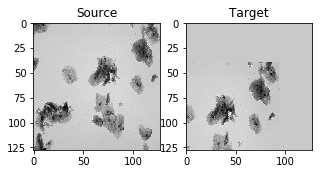

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def two_up(ref, mov):
    fig, (a, b) = plt.subplots(1, 2, figsize=(5, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Source')
    b.imshow(mov, cmap='gray')
    b.set_title('Target')
    plt.show()

def compare_all(ref, mov, pred):
    fig, (a, b, c) = plt.subplots(1, 3, figsize=(8, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Source')
    b.imshow(mov, cmap='gray')
    b.set_title('Target')
    c.imshow(pred, cmap='gray')
    c.set_title('Predicted')
    plt.show()
    
def compare_diff(ref,mov,pred):
    fig, (a, b, c) = plt.subplots(1, 3, figsize=(8, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Source')
    b.imshow(mov, cmap='gray')
    b.set_title('Target')
    c.imshow(abs(pred-mov), cmap='gray')
    c.set_title('Difference')
    plt.show()

from imageio import imread
tm1 = imread(original_data_dir + '/Tp26_Y000_X000_040_0015_A.tif')
tm2 = imread(original_data_dir + '/Tp26_Y000_X000_040_0015_B.tif')
two_up(tm1, tm2)

## HomographyNet

As the rigid version, we output two x,y parameters which represent the displacement

In [5]:
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Dense, Flatten, MaxPooling2D, Input, Activation, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K

def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def conv_block(m, filters):
    kernel = (3, 3)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    return BatchNormalization()(m)

def conv_group(m, filters):
    m = conv_block(m, filters)
    m = conv_block(m, filters)
    return MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(m)

def homography_regression_model(input_dims):
    input_shape=(*input_dims, 2)
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # 4x 64
    x = conv_group(input_layer, 64) # 1,2
    x = conv_group(x,           64) # 3,4
    # 4x 128
    x = conv_group(x,           128) # 1,2
    x = conv_block(x,           128) # 3
    x = conv_block(x,           128) # 4
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, name='FC_1024')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(2, name='output')(x)
    
    return Model(inputs=input_layer, outputs=[out])

Using TensorFlow backend.


In [6]:
from keras.optimizers import SGD, Adam

img_size = tm1.shape[:2]

# opt = SGD(lr=0.005, momentum=0.9, decay=0.0015)
opt = SGD(lr=0.001, momentum=0.9, decay=0.0)
# opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
__________

## Data Generators

We generate the "seemingly infinite training data" on the fly by using Keras' DataGenerators.

In [7]:
import math
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import rotate


def h_string_to_arr(s):
    return np.array(list(map(lambda x: np.float32(x), s.split(','))))
    

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size, train_dir):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size
        self.train_dir = train_dir

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def invert(self, im):
        return abs(255 - im)
    
    def read_images(self, fname):
        ext = '.tif'
        base = path.join(self.train_dir, fname)
        a = self.invert(img_to_array(load_img(base + '_A' + ext, grayscale=True)))
        b = self.invert(img_to_array(load_img(base + '_B' + ext, grayscale=True)))
        return np.dstack((a,b))
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 2))
        y = np.zeros(shape=(batch_size, 2))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,row in enumerate(batch):
            fname, h_str = row[1:]
            X[j] = self.read_images(fname)
            y[j] = h_string_to_arr(h_str)
        return (X, y)

class AugmentedDataGenerator(DataGenerator):
    '''
    Same as DataGenerator but augments data by overriding `read_image`.
    '''

    def read_images(self, fname):
        '''
        reflection augmentations
        '''
        ext = '.tif'
        base = path.join(self.train_dir, fname)
        a = self.invert(img_to_array(load_img(base + '_A' + ext, grayscale=True)))
        b = self.invert(img_to_array(load_img(base + '_B' + ext, grayscale=True)))
        flip_dir = np.random.choice([None, 0, 1, 2])
        if flip_dir == None:
            return np.dstack((a,b))
        elif flip_dir < 2: # flip horizontal or vertical
            a = np.flip(a, flip_dir)
            b = np.flip(b, flip_dir)
        else: # flip_dir == 2, flip both directions
            a = np.flip(np.flip(a, 0),1)
            b = np.flip(np.flip(b, 0),1)
        return np.dstack((a,b))    
    
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

def step_scheduler(epoch, lr):
    step = int(epochs/3)
    if epoch % step == 0 and epoch > 0: # if this is a step epoch:
        new_lr = lr * 0.5 # decrease lr by some factor
        print('learning rate decreased from %f to %f' % (lr, new_lr))
        return new_lr   
    return lr # no change

lrScheduler = LearningRateScheduler(step_scheduler)

tmp directory already exists


## Training

> We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.The networks are trained for for 90,000 total iterations using a batch size of 64.


In [8]:
from datetime import date

batch_size = 32
total_iterations = 60000

steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

epochs = int(total_iterations / steps_per_epoch)

training_generator   = DataGenerator(train_paths, batch_size, img_size, original_data_dir)
validation_generator = DataGenerator(valid_paths, batch_size, img_size, original_data_dir)

# descriptive weight file naming
out_name = 'multiscale-hnet-weights-%d-%d-holdout_40k-%s' % \
           (batch_size, img_size[0], date.today().isoformat())
checkpointer = ModelCheckpoint(filepath='tmp/%s.hdf5' % out_name, 
                               verbose=1, save_best_only=True)

print('Epochs:            %d' % epochs)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Epochs:            42
Traning images:    45600
Validation images: 11400
Training steps:    1425
Validation steps:  356


In [9]:
hist = my_model.fit_generator(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              workers=3,
                              verbose=2,
                              callbacks=[history, checkpointer, early_stopping, lrScheduler]
                             )

Epoch 1/42
 - 250s - loss: 1.3321 - val_loss: 0.6183

Epoch 00001: val_loss improved from inf to 0.61828, saving model to tmp/multiscale-hnet-weights-32-128-holdout_40k-2019-05-20.hdf5
Epoch 2/42
 - 247s - loss: 0.8695 - val_loss: 0.4379

Epoch 00002: val_loss improved from 0.61828 to 0.43790, saving model to tmp/multiscale-hnet-weights-32-128-holdout_40k-2019-05-20.hdf5
Epoch 3/42
 - 248s - loss: 0.6479 - val_loss: 0.3327

Epoch 00003: val_loss improved from 0.43790 to 0.33272, saving model to tmp/multiscale-hnet-weights-32-128-holdout_40k-2019-05-20.hdf5
Epoch 4/42
 - 247s - loss: 0.4816 - val_loss: 0.2788

Epoch 00004: val_loss improved from 0.33272 to 0.27885, saving model to tmp/multiscale-hnet-weights-32-128-holdout_40k-2019-05-20.hdf5
Epoch 5/42
 - 247s - loss: 0.3690 - val_loss: 0.2032

Epoch 00005: val_loss improved from 0.27885 to 0.20315, saving model to tmp/multiscale-hnet-weights-32-128-holdout_40k-2019-05-20.hdf5
Epoch 6/42
 - 248s - loss: 0.3009 - val_loss: 0.2254

Epoch

## Results inspection

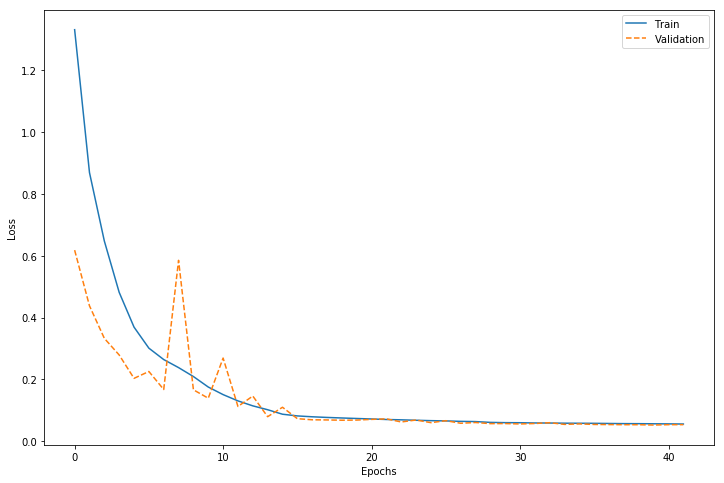

In [10]:
import json

with open('tmp/%s.json' % out_name, 'w') as fh:
    fh.write(json.dumps(hist.history))

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Train')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# load model if needed
my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.load_weights('tmp/multiscale-hnet-weights-32-128-40k-2019-05-20.hdf5')

[-15.85498489  -8.89425982] 

 [-16.4701    -3.368532]


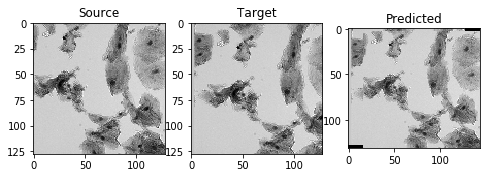

In [19]:
import cv2
from numpy.random import randint
from skimage.transform import resize

def alter_pt_constant(pt,x,y):
    return (pt[0] + x, pt[1] + y)

def create_multiscale_rigid_patches(im, w_min, w_max, final_size, max_overlap):
    '''
    Create pairs of patches from an image
    '''
    size = randint(w_min, w_max)
    r = int(max_overlap * size)
    im = np.pad(im, int(2*r), mode='constant', constant_values=np.median(im))
    while True:
        # generate two random points, r to size-r so as to not go over the edge
        x = randint(2*r, im.shape[1]-size-2*r)
        y = randint(2*r, im.shape[0]-size-2*r)

        A = im[y:y+size,x:x+size] # this is our 'reference' image
        A = cv2.resize(A, final_size, interpolation=cv2.INTER_CUBIC)
        
        # generate x,y displacements
        x_dis, y_dis = randint(-r, r+1, 2)
        
        B = im[y+y_dis:y+size+y_dis, 
               x+x_dis:x+size+x_dis]
        B = cv2.resize(B, final_size, interpolation=cv2.INTER_CUBIC)
        
        # make sure the images actually have contents.
        thresh = 750
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            scaled_dis = [ x_dis / size, y_dis / size]
            return A, B, scaled_dis 
        
import sys
sys.path.insert(0, '../src')
from util import pad,merge
    
def invert(im):
    return abs(255 - im)
    
test_dir = r'../data/hnet_multiscale_training_128_holdout_2019-05-20/holdout'
im1 = imread(test_dir + '/Tp26_Y003_X002_040.tif')
# im1 = cv2.resize(im1, (672,512), interpolation=cv2.INTER_NEAREST)

p_a, p_b, H_act = create_multiscale_rigid_patches(im1, 512, 1024, img_size, 0.8)
H_act = np.array(H_act) * img_size[0]

test_im = np.dstack((invert(p_a), invert(p_b)))
test_im = test_im.reshape(1, *test_im.shape)

H_2pt = my_model.predict(test_im)[0]

# H_2pt[0] *= (np.sign(H_2pt[0]) - H_2pt[0]) * img_size[0]
# H_2pt[1] *= (np.sign(H_2pt[1]) - H_2pt[1]) * img_size[0]

H_2pt[0] *=  img_size[0]
H_2pt[1] *=  img_size[0]

predicted = merge(p_a, p_b, H_2pt[0], H_2pt[1])
# predicted = merge(p_a, p_b, H_act[0], H_act[1])

print(H_act, '\n\n', H_2pt)
compare_all(p_a, p_b, predicted)

[-26.106264   4.791616]


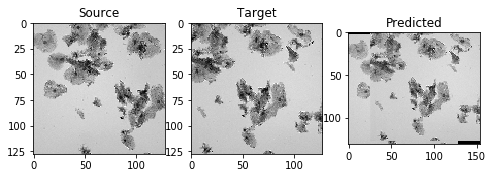

In [21]:
test_dir = r'../data/learning'

im1 = cv2.imread(test_dir + '/Tp26_Y000_X005_040.tif', cv2.IMREAD_UNCHANGED)[:,320:]
im1 = cv2.resize(im1, img_size, interpolation=cv2.INTER_CUBIC)

im2 = cv2.imread(test_dir + '/Tp26_Y000_X006_040.tif', cv2.IMREAD_UNCHANGED)[:,:1024]
im2 = cv2.resize(im2, img_size, interpolation=cv2.INTER_CUBIC)

test_im = np.dstack((invert(im1), invert(im2)))
test_im = test_im.reshape(1, *test_im.shape)
H_2pt = my_model.predict(test_im)[0]
# predicted = pad(im1, *H_2pt[0])

H_2pt[0] *= img_size[0]
H_2pt[1] *= img_size[0]

predicted = merge(im2, im1, H_2pt[0], H_2pt[1])

print(H_2pt)
compare_all(im1, im2, predicted)